In [ ]:
!cp drive/MyDrive/satdata.zip .
!unzip satdata.zip

In [ ]:
# !wget http://coder.weathon.top:8888/screenshots_resized.zip

In [ ]:
# import tensorflow_datasets as tf
import tensorflow as tf
# try:
#   del pix2pix # yaochongxingdaoru? 
# except:
#   pass
# from tensorflow_examples.models.pix2pix import pix2pix
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from PIL import Image
# AUTOTUNE = tf.data.AUTOTUNE

# Re-start from here

In [ ]:
import tensorflow as tf

In [ ]:
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset


In [ ]:

def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
  """Downsamples an input.

  Conv2D => Batchnorm => LeakyRelu

  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_norm: If True, adds the batchnorm layer

  Returns:
    Downsample Sequential Model
  """
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.

  Conv2DTranspose => Batchnorm => Dropout => Relu

  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer

  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result



In [ ]:

def unet_generator(output_channels, norm_type='batchnorm'):
  """Modified u-net generator model (https://arxiv.org/abs/1611.07004).

  Args:
    output_channels: Output channels
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.

  Returns:
    Generator model
  """

  down_stack = [
      downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
      downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
      downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
      downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
  ]

  up_stack = [
      upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
      upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
      upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [ ]:
def discriminator(norm_type='batchnorm', target=True):
  """PatchGan discriminator model (https://arxiv.org/abs/1611.07004).

  Args:
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
    target: Bool, indicating whether target image is an input or not.

  Returns:
    Discriminator model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  x = inp

  if target:
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4, norm_type)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4, norm_type)(down2)  # (bs, 32, 32, 256)
  down4 = downsample(256, 4, norm_type)(down3)  # (bs, 32, 32, 256)
  down5 = downsample(256, 4, norm_type)(down4)  # (bs, 32, 32, 256)
  down6 = downsample(256, 4, norm_type)(down5)  # (bs, 32, 32, 256)




  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down6)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  if norm_type.lower() == 'batchnorm':
    norm1 = tf.keras.layers.BatchNormalization()(conv)
  elif norm_type.lower() == 'instancenorm':
    norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(
      1, 4, strides=1,
      kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)


In [ ]:
OUTPUT_CHANNELS = 3

generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = discriminator(norm_type='instancenorm', target=False)
discriminator_y = discriminator(norm_type='instancenorm', target=False)

In [ ]:
IMG_WIDTH = 320
IMG_HEIGHT = 320
grassland_sample = np.array(Image.open("sat/0.png").convert("RGB").resize((256, 256))).reshape(1, 256, 256, 3)
desert_sample = np.array(Image.open("minecraft/2022-01-22_19.47.33.png").resize((256, 256)).convert('RGB')).reshape(1, 256, 256, 3)
#It is the size problem, but it is 256, not 286

In [ ]:
generator_g.input_shape
# zebra -> real horse -> minecraft

(None, None, None, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


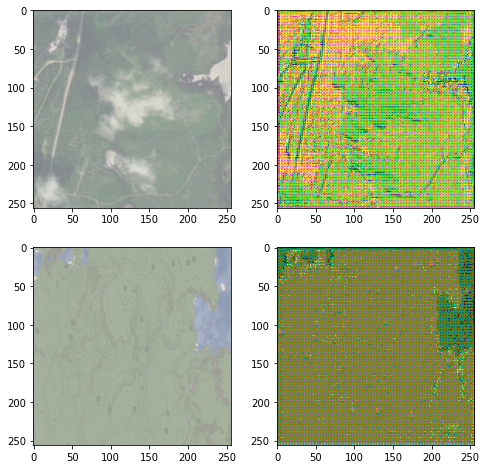

In [ ]:
to_desert = generator_g(grassland_sample)
to_grassland = generator_f(desert_sample)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [grassland_sample/255, to_desert, desert_sample/255, to_grassland]
# title = ['Sample Desert', 'To Grass Land', 'Grass Land', 'To Desert']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  # plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

In [ ]:
!rm -rf checkpoints/

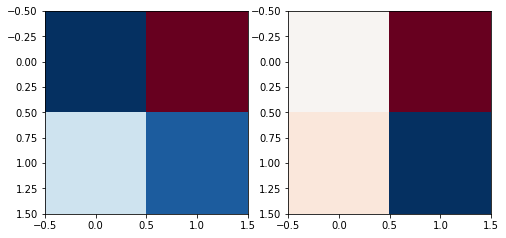

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
# plt.title('Is this real?')
plt.imshow(np.array(discriminator_y(grassland_sample)).reshape(2,2), cmap='RdBu_r')

plt.subplot(122)
# plt.title('Is this minecraft?')
plt.imshow(np.array(discriminator_y(desert_sample)).reshape(2,2), cmap='RdBu_r')

plt.show()

In [ ]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint) #need to delete old
  print ('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 40

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input.astype("float32"))

  # plt.figure(figsize=(12, 12))
  print(np.min(prediction))
  display_list = np.array(prediction[0])/np.max(prediction)
  plt.imshow(display_list)
  # title = ['Minecraft', "To Real"]
  # for i in range(2):
  #   plt.subplot(1, 2, i+1)
  #   plt.title(title[i])
  #   # getting the pixel values between [0, 1] to plot it.
  #   plt.imshow(display_list[i] * 0.5 + 0.5)
  #   plt.axis('off')
  # plt.show()

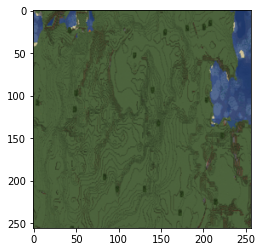

In [ ]:
plt.imshow(desert_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-1.0


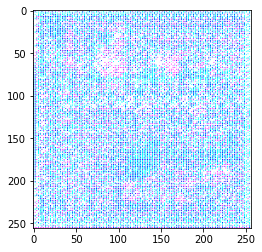

In [ ]:
generate_images(generator_g, desert_sample)
# plt.imshow(sample_minecraft[0])

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [ ]:
!cd /content/

In [ ]:
!cp drive/MyDrive/croped.zip .

In [ ]:
!mv sat sa.bak


In [ ]:
!unzip croped.zip -d sat/

In [ ]:
!mv sat/croped/* sat/
!rmdir sat/croped

In [ ]:
minecraft_images = os.listdir("minecraft")
print("Images from minecraft: %s" %len(minecraft_images))

real_images = os.listdir("sat")
print("Images from real world: %s" %len(real_images))



Images from minecraft: 386
Images from real world: 476


In [ ]:
import random

In [ ]:
random.shuffle(minecraft_images)

In [ ]:
# minecraft_images xkoukunxkouxkounanshouwhyzhegehiuibianchengnonebuxuyaodengyu

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving checkpoint for epoch 40 at ./checkpoints/train/ckpt-12
Time taken for epoch 40 is 44.630773305892944 sec



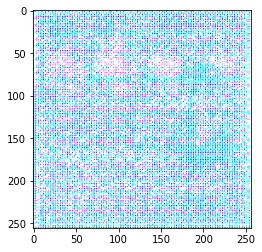

In [ ]:
import random
for epoch in range(EPOCHS):
  start = time.time()
  random.shuffle(real_images)
  random.shuffle(minecraft_images)
  n = 0
  for image_id in range(min( len(real_images) , len(minecraft_images) )):
    minecraft_image = np.array(
        Image.open("minecraft/"+minecraft_images[image_id]).resize((256,256)).convert("RGB")
    ).reshape(1,256,256,3).astype("float32")

    real_image = np.array(
        Image.open("sat/"+real_images[image_id]).resize((256,256)).convert("RGB")
    ).reshape(1,256,256,3).astype("float32")

    train_step(minecraft_image, real_image)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # 使用一致的图像（sample_horse），以便模型的进度清晰可见。
  # generate_images(generator_g, minecraft_image)
  plt.imshow(generator_g(minecraft_image)[0])
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


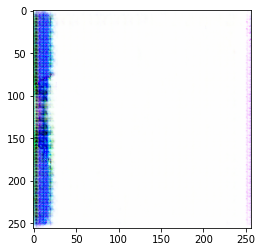

In [ ]:
plt.imshow(generator_g(minecraft_image)[0])

In [ ]:
np.array(bg).dtype

dtype('uint8')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


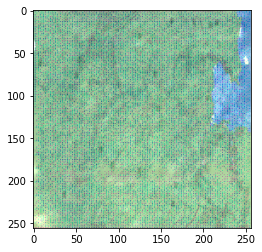

In [ ]:
bg = Image.open("sat/100.png").resize((256,256)).convert("RGB")
t = Image.open("minecraft/2022-01-22_19.47.31.png").resize((256,256)).convert("RGB")
top = (generator_g(np.array(t).reshape(1,256,256,3))[0])*30
plt.imshow(np.array(top).astype("int")+(np.array(bg)+np.array(t).astype("int")))

In [ ]:
generator_g.save("g")

INFO:tensorflow:Assets written to: g/assets


In [ ]:
!zip g.zip g -r

  adding: g/ (stored 0%)
  adding: g/variables/ (stored 0%)
  adding: g/variables/variables.index (deflated 60%)
  adding: g/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: g/keras_metadata.pb (deflated 94%)
  adding: g/saved_model.pb (deflated 91%)
  adding: g/assets/ (stored 0%)
